# Import Example Data Sets

In [1]:
import sys
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [16 / 1.5, 10 / 1.5]   # inch / cm = 2.54
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
# plt.rcParams['savefig.frameon'] = False
from math import *

The library **sampledata** provides a number of datasets as pandas dataframes. 

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import exampledata

In [3]:
NOISE = 0

## Periodic Sine Curves with Noise

sine_data() provides a sine curve with given period and amplitude, distorted with random noise (with given distribution). 

We get two dataframes - a complete one to plot the true population, and 25 random samples representing noisy measurements:

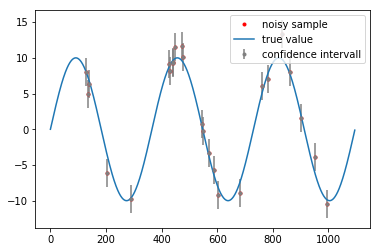

In [4]:
df_all = exampledata.sine_data()
df_z = exampledata.sine_data(n_sample=25, noise_std = 1)

plt.plot(df_z.x, df_z.measurement, '.', label='noisy sample', color = "red")
plt.plot(df_all.x, df_all.truez, label="true value")
plt.errorbar(df_z.x, df_z.measurement, df_z.confidence95, fmt='.',
             label='confidence intervall', color="grey")

plt.legend()
plt.show()

a number of parameters can be used to obtain different datasets, see below (here, the sample is taken afterwards for better code readability).

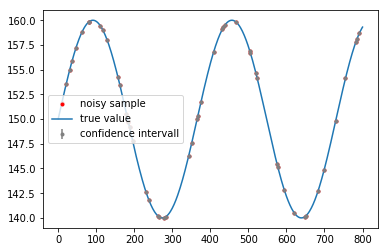

In [5]:
df_all = exampledata.sine_data(start = 0,  stop = 800,  # intervall for predictor
              resolution = 500,   # number of samples to create in interval
              period = 365, amplitude = 10,  # shape of sine curve 
              noise_type="gaussian",   # type of noise
              noise_mean = 0,  # mean of noise
              noise_std = NOISE,
              true_mean=150)  # standard deviation of noise
df_z = df_all.sample(50)

plt.plot(df_z.x, df_z.measurement, '.', label='noisy sample', color = "red")
plt.plot(df_all.x, df_all.truez, label="true value")
plt.errorbar(df_z.x, df_z.measurement, df_z.confidence95, fmt='.',
             label='confidence intervall', color="grey")

df_z.to_excel(r".\example_data\Periodic Sine\example_5.xlsx")

plt.legend()
plt.show()

In [6]:
df_z

,x,y,truez,noise,confidence95,measurement
371,594.789579,0,142.775601,0.0,0.0,142.775601
23,36.873747,0,155.926422,0.0,0.0,155.926422
50,80.160321,0,159.816614,0.0,0.0,159.816614
494,791.983968,0,158.713987,0.0,0.0,158.713987
98,157.114228,0,154.248291,0.0,0.0,154.248291
122,195.591182,0,147.787053,0.0,0.0,147.787053
166,266.132265,0,140.089838,0.0,0.0,140.089838
115,184.368737,0,149.699212,0.0,0.0,149.699212
234,375.150301,0,151.696612,0.0,0.0,151.696612
29,46.492986,0,157.172265,0.0,0.0,157.172265


## Storing and Modifying Data

The dataframe can be saved (see cell above), and later be loaded again.
The following table ist a concanenated dataset for Example 2, with measurements of different confidence intervals.

In [7]:
P = np.array(df_z.dropna()[['x','y','truez']])
P

array([[594.78957916,   0.        , 142.7756009 ],
       [ 36.87374749,   0.        , 155.92642172],
       [ 80.16032064,   0.        , 159.8166141 ],
       [791.98396794,   0.        , 158.71398705],
       [157.11422846,   0.        , 154.2482911 ],
       [195.59118236,   0.        , 147.78705301],
       [266.13226453,   0.        , 140.08983772],
       [184.36873747,   0.        , 149.69921191],
       [375.1503006 ,   0.        , 151.69661184],
       [ 46.49298597,   0.        , 157.17226455],
       [238.87775551,   0.        , 141.76362067],
       [230.86172345,   0.        , 142.62137946],
       [575.5511022 ,   0.        , 145.41446212],
       [682.96593186,   0.        , 142.70644428],
       [343.08617234,   0.        , 146.28048972],
       [431.26252505,   0.        , 159.06862553],
       [698.99799599,   0.        , 144.84508097],
       [505.01002004,   0.        , 156.72175875],
       [620.44088176,   0.        , 140.51457358],
       [466.53306613,   0.     

In [8]:
from scipy.spatial.distance import pdist, squareform
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )  # sample difference
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

C:\Users\jomz\AppData\Local\conda\conda\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


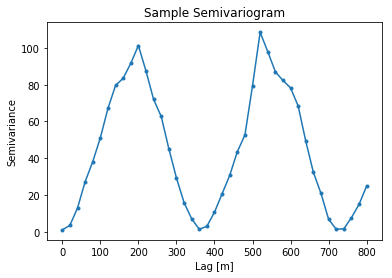

In [9]:
# bandwidth, plus or minus bw meters
bw = 20
# lags in 25 days increments from zero to 2000
hs = np.arange(0, 4000, bw)
sv = SV( P, hs, bw )
plt.plot( sv[0], sv[1], '.-' )
#plt.errorbar(df_z.x, df_z.truez, df_z.noise, fmt='.',
             #label='confidence intervall', color="grey")
plt.xlabel('Lag [m]')
plt.ylabel('Semivariance')
plt.title('Sample Semivariogram') ;
#savefig('sample_semivariogram.png',fmt='png',dpi=200)

In [10]:
def opt( fct, x, y, C0, parameterRange=None, meshSize=1000 ):
    if parameterRange == None:
        parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]


In [11]:
import svmodels

In [12]:

def hole_N (h, C0, a, Cn=0):
    #from Triki et al. p.1600 (Dowdall et al. 2003)
    if type(h) == np.float64:
        # calculate the hole function
        if h == 0:
            return Cn
        if h <= pi*2*a: 
            return (Cn+(C0-Cn)*(1-(sin(h/a ))/(h/a) ))
        if pi*2*a < h <= pi*4*a:
            return (Cn+(C0-Cn)*(1-(sin(h/a ))/(0.6*h/a) ))
        if h > pi*4*a:
            return (Cn+(C0-Cn)*(1-(sin(h/a ))/(0.4*h/a) ))
    # if h is an iterable
    else:
        # calcualte the hole function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        return map( hole_N, h, a, C0, Cn )

In [38]:
def cosine (h, a, C0, Cn=0, wavelength=365.24):
    
    assert wavelength is not None, "wavelength must be specified"
    
    if type(h) == np.float64:
        if h >= 0:
            return Cn+C0-(C0-Cn)*(exp(-(3*h)/a)*cos((2*pi/wavelength)*h))
    else:
        print(a)
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        wavelength = np.ones(h.size) * wavelength
        
        return map(cosine, h, a, C0, Cn, wavelength)

In [39]:
def sine (h, a, C0, Cn=0, wavelength=None):
    if type (h) == np.float64:
        if h <=365.24/pi:
            return (1.0-sin(h/a))
        else:
            return  Cn+(C0-Cn)*(1.0-sin(h/a))     
    
    else:
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        Cn = np.ones(h.size) * Cn
        return map(sine, h, a, C0, Cn )        

In [40]:
365/(2*pi)

58.0915542285418

In [41]:
def cvmodel( P, model, hs=None, bw=None, Cn=None, svrange=None, C0=None):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponential
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    if Cn is None:
        Cn = N(P, hs, bw)
            
    if type(C0) == float:
        C0 = np.float64(C0)
        
    # calculate the sill
    if C0 is None:
        C0 = C( P, hs[0], bw )
    # calculate the optimal parameters
    if svrange is None:
        # calculate the semivariogram
        sv = SV( P, hs, bw )
        svrange = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a=svrange: C0 - model( h, a, C0, Cn=Cn)
    return covfct

10000


Text(0.5,0,u'Lag [m]')

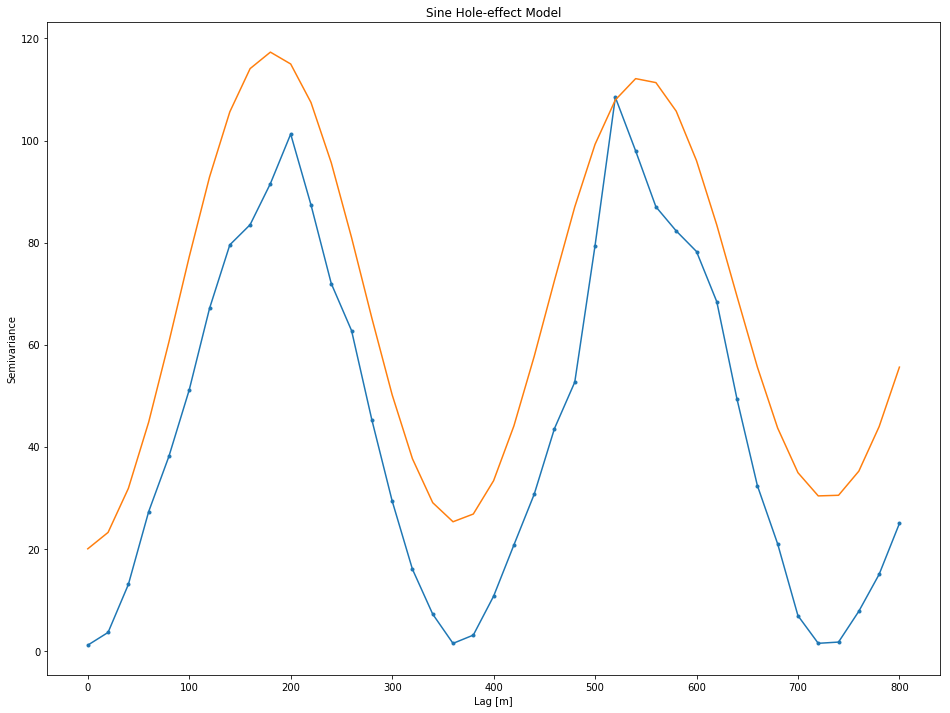

In [42]:

varmodel = cosine
C0=60.0
sp = cvmodel( P, model=varmodel, hs=np.arange(0,4000,20), bw=bw,  Cn=10, svrange=10000, C0=C0)
#C0 = C( P, hs[0], bw )

plt.plot( sv[0], sv[1], '.-' )
plt.plot( sv[0], C0 - sp( sv[0] ) ) ;
plt.title('Sine Hole-effect Model')
plt.ylabel('Semivariance')
plt.xlabel('Lag [m]')
#plt.savefig('Valid_Svmodel_hole_New50.png',fmt='png',dpi=300)

In [43]:
def krige( P, covfct, u, N ):
    '''
    Input  (P)     ndarray, data
           (covfct) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''

    assert N < len(P) + 1, "Number of Neighbors greater than number of data points"

    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
    K = np.identity(N)*(2*NOISE)**2+K  # Variance (2 times std (+/-) squared of sample set) is added as identity matrix 
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return (float( estimation ), k, K, weights)

In [44]:
#np.sqrt(1.3823)
#1.175712/2


In [45]:
# sampling intervall:
X0, X1 = 0., 1600.

# number of samples
n =2000
dx = (X1-X0)/n
print("Sampling resolution: {:.2f} days".format(dx))

# number of neighbors:
nn = 25
u = (400, 0)  # (x,y) - coordinates of unsampled points


Sampling resolution: 0.80 days


In [46]:
Z = np.zeros(n)
V = np.zeros(n)
for i in range(n):

    h, k, K, weights = krige( P, sp, (dx*i, 0), nn )
    Z[i] = h
    #plt.plot (Z)
    #plt.show()
    v = C0 - np.dot(k.T, weights)
    V[i] = max (v, 0)

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
1000

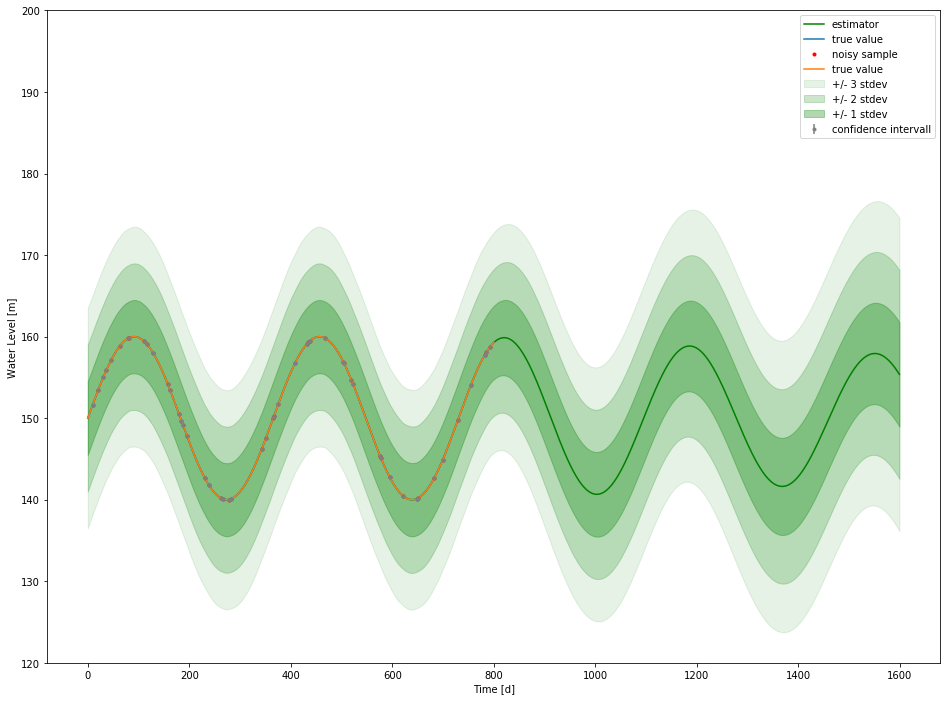

In [47]:
plt.rcParams["figure.figsize"] = (16, 12)
plt.fill_between([i*dx for i in range(n)], Z-3*np.sqrt(V), Z+3*np.sqrt(V), color='green', alpha=0.1, label="+/- 3 stdev")
plt.fill_between([i*dx for i in range(n)], Z-2*np.sqrt(V), Z+2*np.sqrt(V), color='green', alpha=0.2, label="+/- 2 stdev")
plt.fill_between([i*dx for i in range(n)], Z-1*np.sqrt(V), Z+1*np.sqrt(V), color='green', alpha=0.3, label="+/- 1 stdev")
plt.plot([i*dx for i in range(n)], Z, "g-", label="estimator")
plt.plot(df_all.x, df_all.truez, label="true value")

plt.plot(df_z.x, df_z.measurement, '.', label='noisy sample', color = "red")
plt.plot(df_all.x, df_all.truez, label="true value")
plt.errorbar(df_z.x, df_z.measurement, df_z.confidence95, fmt='.',
             label='confidence intervall', color="grey")


plt.legend(loc='upper right')
plt.ylabel('Water Level [m]')
plt.xlabel('Time [d]')

x1,x2,y1,y2 = plt.axis()

plt.axis((x1,x2,120, 200))

#plt.axis((260, 280 ,140, 141))
#plt.savefig("Valid_result_hole_New50P.png")
plt.show()

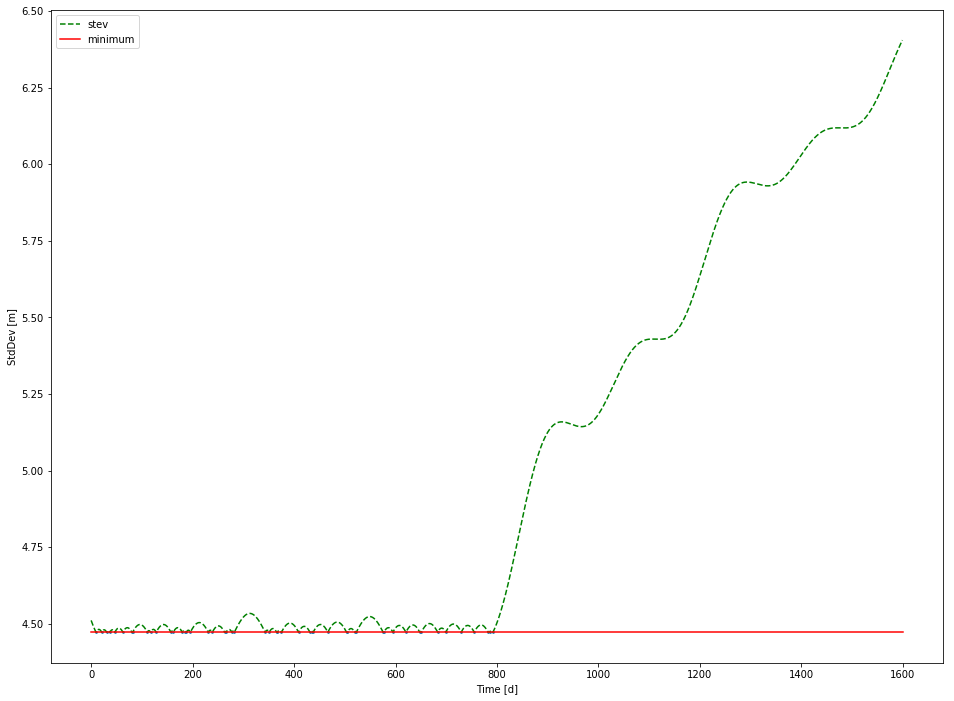

4.472189745404533


In [48]:
plt.plot([i*dx for i in range(n)], np.sqrt(V), "g--", label="stev")
#plt.plot((X0, X1),(np.sqrt(V).min(), np.sqrt(V).min()), "r-", label="size of confidence from global Sill")
plt.plot((X0, X1),(np.sqrt(V).min(), np.sqrt(V).min()), "r-", label="minimum")
plt.legend(loc='upper left')
#plt.scatter(df_Qts.X, (df_Qts.MESSWERT_NUM-448)*30, c="r", label="sample", s=3)

#plt.scatter(df_Qts.X, np.ones_like(df_Qts.X), c="r", label="sample", s=3)

plt.ylabel('StdDev [m]')
plt.xlabel('Time [d]')
#plt.axis((-1,10,0, 25))
#plt.savefig("result_hole_N_model_highAmplitude_95%interval40nn.png")

plt.scatter(df_z.x,np.ones(len(df_z))*np.sqrt(V).min(), s=3)

_ = plt.show()

print(np.sqrt(V).min())

In [49]:
V.min()

20.00048111890146

In [50]:
Vs = []
for i in range(len(df_z)):
    try:
        h, k, K, weights = krige( P, sp, (df_z.iloc[i].x, 0), nn )  
    except ValueError as e:
        print e.message
    v = C0 - np.dot(k.T, weights)
    v = max(v, 0)
    Vs.append(sqrt(v))

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


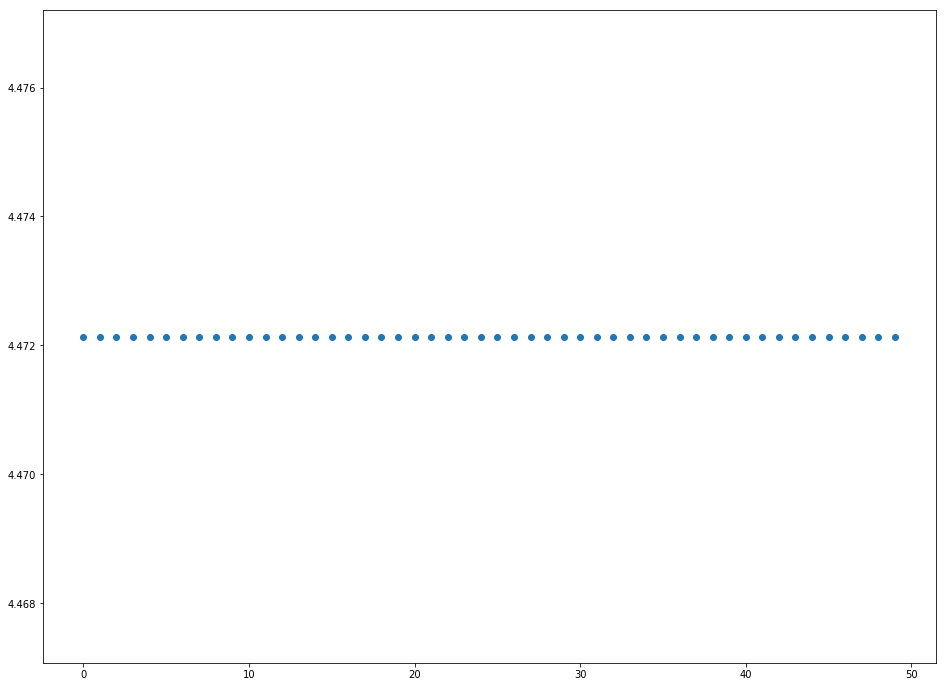

In [51]:
plt.scatter(range(len(Vs)),Vs)